In [1]:
import time
from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave
import numpy as np
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.
/home/truename/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/truename/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/truename/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/truename/anaconda3/lib/python3.7/site-packag

In [2]:
from keras.applications import vgg19
from keras import backend as K

## Исходные изображения и параметры алгоритма

In [3]:
CONTENT_IMG_PATH = './data/moscow.jpg'
STYLE_IMG_PATH = './data/monet.jpg'

ITERATIONS = 3  # число итераций
STYLE_WEIGHT = 0.5  # веса функции потерь стиля
CONTENT_WEIGHT = 0.75  # вес функции потерь содержимого
VARIATION_WEIGHT = 0.99  # вес функции потерь разницы между соседними пикселами

## Задаем размеры выходного изображения

In [4]:
width, height = load_img(CONTENT_IMG_PATH).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## Визуализируем исходные изображения

Text(0.5,1,'Content Image')

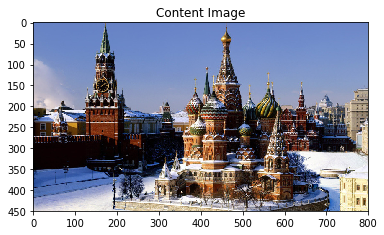

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(plt.imread(CONTENT_IMG_PATH))
plt.title('Content Image')

Text(0.5,1,'Style Image - Monet')

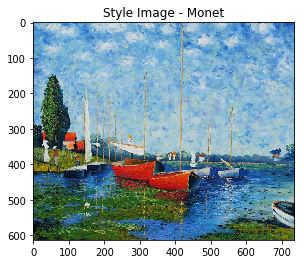

In [6]:
plt.imshow(plt.imread('./data/monet.jpg'))
plt.title('Style Image - Monet')

Text(0.5,1,'Style Image - Picasso')

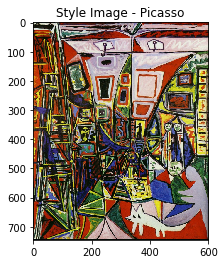

In [7]:
plt.imshow(plt.imread('./data/picasso.jpg'))
plt.title('Style Image - Picasso')

In [8]:
# препроцессинг изображения для отправки в сеть vgg19
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# преобразуем сгенерированный тензор в изображение
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # возвращаем смещение относительно среднего
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# загружаем изображения и подготоваливаем к прогону через vgg
base_image = K.variable(preprocess_image(CONTENT_IMG_PATH))
style_reference_image = K.variable(preprocess_image(STYLE_IMG_PATH))

# создаем буфер для сохранения результирующего изображения
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# объединяем изображения в батч
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# загружаем предобученную сеть
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# словарь выходов слоев
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 99s 1us/step
Model loaded.


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Задаем функцию потерь

In [10]:
# матрица ковариации
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# функция потерь стиля вычисляется на основе матрицы ковариации
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# функция потерь для содержания
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# накладываем ограничение на похожесть соседних пикселей
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## Объединяем функции потерь

In [11]:
loss = K.variable(0.)

# контент вычисляем только для слоя 'block5_conv2'
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += CONTENT_WEIGHT * content_loss(base_image_features,
                                      combination_features)

# функцию потерь стиля вычисляем на всех сверточных слоях
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (STYLE_WEIGHT / len(feature_layers)) * sl
    
# добавляем функцию потерь на похожесть соседних пикселей
loss += VARIATION_WEIGHT * total_variation_loss(combination_image)

## Градиенты полученного изображения от функции потерь

In [12]:
# градиенты считаются автоматически по правилу дифференцирования сложной функции
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# вычисляем функцию потерь и градиенты
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# обертка для класса оптимизатора
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

## Запускаем процесс стилизации изображения

In [13]:
# инициализируем исходным изображением
x = preprocess_image(CONTENT_IMG_PATH)

for i in range(ITERATIONS):
    print('Start of iteration', i)
    start_time = time.time()
    # вычисляем градиент и обновляем значения
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # сохраняем сгенерированное изображение
    img = deprocess_image(x.copy())
    fname = 'neural_style_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2868952600.0


/home/truename/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Image saved as neural_style_0.png
Iteration 0 completed in 625s
Start of iteration 1
Current loss value: 1818516500.0
Image saved as neural_style_1.png
Iteration 1 completed in 683s
Start of iteration 2
Current loss value: 1508048000.0
Image saved as neural_style_2.png
Iteration 2 completed in 694s


## Результат

Text(0.5,1,'Monet 0')

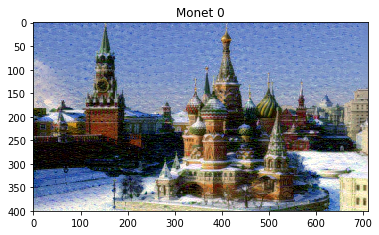

In [14]:
plt.imshow(plt.imread('./data/styled_monet_0.png'))
plt.title('Monet 0')

Text(0.5,1,'Monet 1')

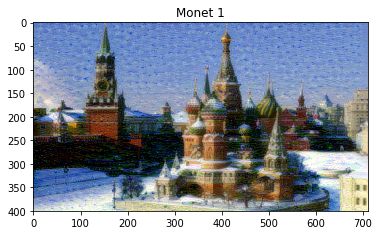

In [15]:
plt.imshow(plt.imread('./data/styled_monet_1.png'))
plt.title('Monet 1')

Text(0.5,1,'Picasso 0')

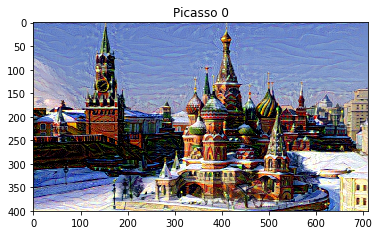

In [16]:
plt.imshow(plt.imread('./data/styled_picasso_0.png'))
plt.title('Picasso 0')

Text(0.5,1,'Picasso 1')

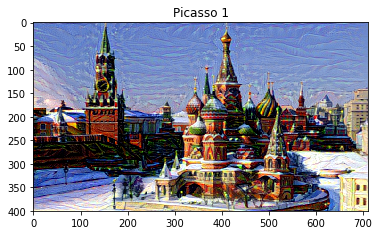

In [17]:
plt.imshow(plt.imread('./data/styled_picasso_1.png'))
plt.title('Picasso 1')